In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import math
import os
import warnings
from multiprocessing import cpu_count
import optuna

warnings.simplefilter('ignore')

### ファイルの読み込み

In [36]:
train_data = pd.read_csv('../data/input/train_df.csv')
test_data = pd.read_csv('../data/input/test_df.csv')
submission = pd.read_csv('../data/input/submission.csv')
train_data.drop('id', inplace=True, axis=1)
test_data.drop('id', inplace=True, axis=1)

train_data.describe()

,A,B,C,D,E,F,G,H,I,Target
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,-0.394398,0.221046,0.174317,-0.290524,-0.313092,-0.040739,-0.662783,-0.511587,-0.033183,0.657143
std,0.387679,0.312284,0.202982,0.269007,0.380777,0.209958,0.294778,0.405620,0.606647,0.475230
min,-0.882353,-0.557789,-0.606557,-0.858586,-0.966903,-0.457526,-0.994876,-0.966667,-0.989877,0.000000
25%,-0.764706,-0.005025,0.016393,-0.515152,-0.702719,-0.195976,-0.864646,-0.866667,-0.604031,0.000000
50%,-0.411765,0.175879,0.180328,-0.313131,0.000000,-0.044709,-0.748933,-0.633333,-0.014864,1.000000
75%,0.000000,0.417085,0.311475,0.000000,0.000000,0.064829,-0.520068,-0.233333,0.512250,1.000000
max,1.000000,0.989950,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999435,1.000000


### 基本的な変数

In [81]:
obj_column = 'Target' # 目的変数のカラム名
seed = 1000 # なにかにつけて使う乱数シード

In [5]:
def histogram(df):# 各列に対してヒストグラムを出力
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            plt.hist(df[column], bins=50, edgecolor='black')  # ビン数やエッジカラーは適宜調整可能
            plt.title(f'Histogram of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.savefig(f'../data/output/histogram_{column}.jpg')
            plt.cla()
        else:
            # 各カテゴリの出現数を計算
            category_counts = df[column].value_counts()
            # ヒストグラムのプロット
            plt.bar(category_counts.index, category_counts.values, edgecolor='black')
            plt.title(f'Histogram of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.savefig(f'../data/output/histogram_{column}.jpg')
            plt.cla()

In [6]:
def scatter(df):
    for column in df.columns:
        if column == obj_column:
            continue  # 目的変数はスキップ
        if pd.api.types.is_numeric_dtype(df[column]):
            # Aが数値変数の場合は散布図
            sns.scatterplot(x=column, y=obj_column, data=df)
            plt.title(f'Scatter Plot of {obj_column} and {column}')
        else:
            # Aがカテゴリ変数の場合はバイオリンプロット
            sns.violinplot(x=column, y=obj_column, data=df)
            plt.title(f'Violin Plot of {obj_column} and {column}')
        
        plt.xlabel(column)
        plt.ylabel(obj_column)

        plt.savefig(f'../data/output/scatter_{column}.jpg')
        plt.cla()

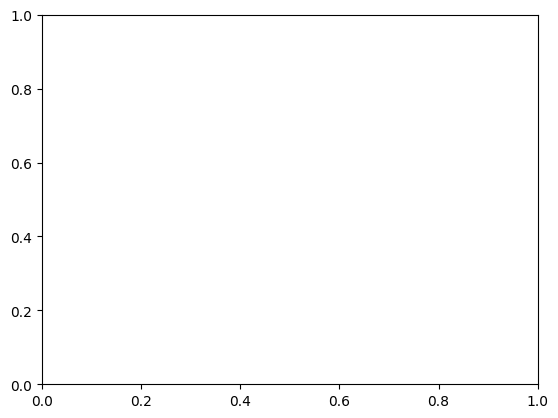

In [7]:
histogram(train_data)
scatter(train_data)

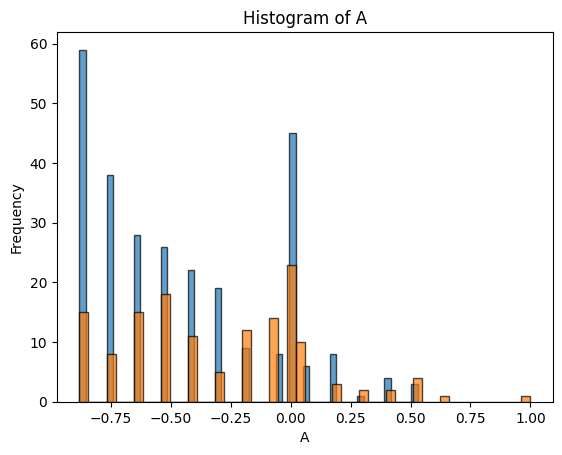

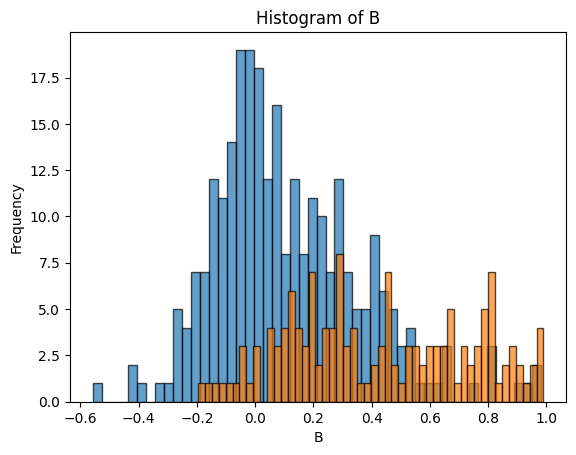

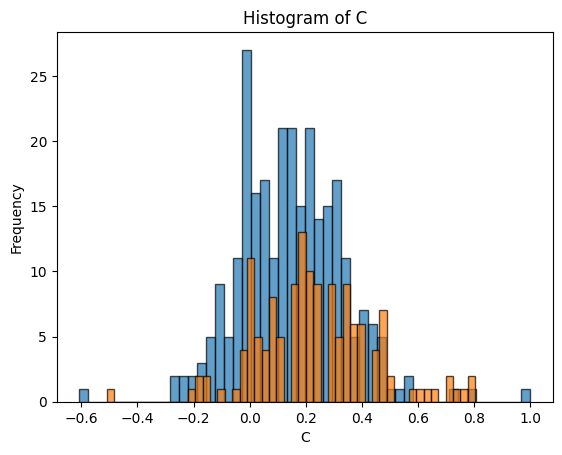

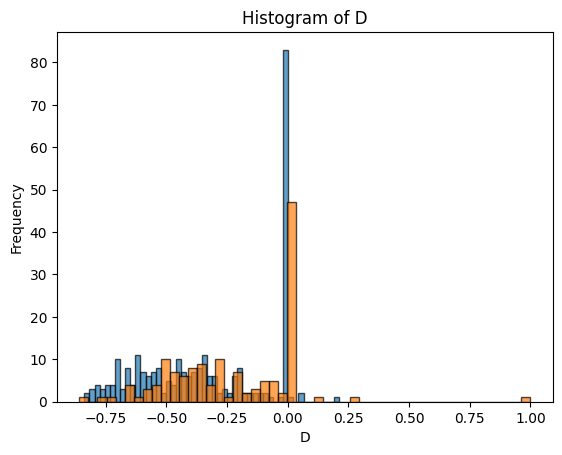

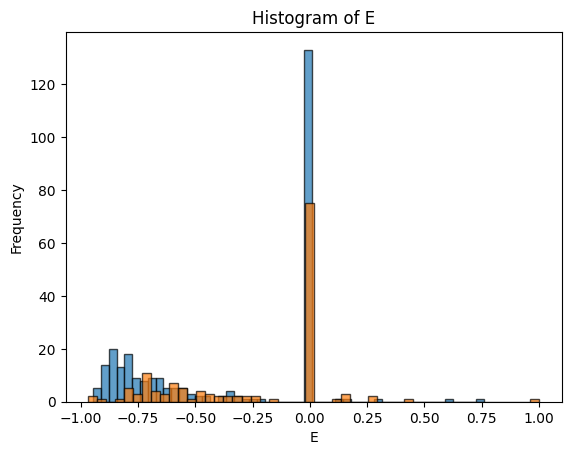

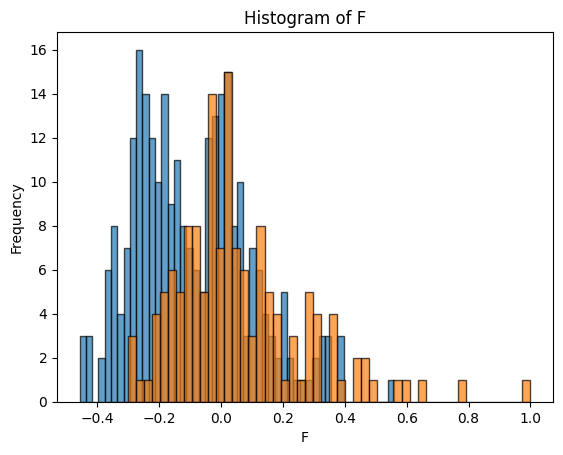

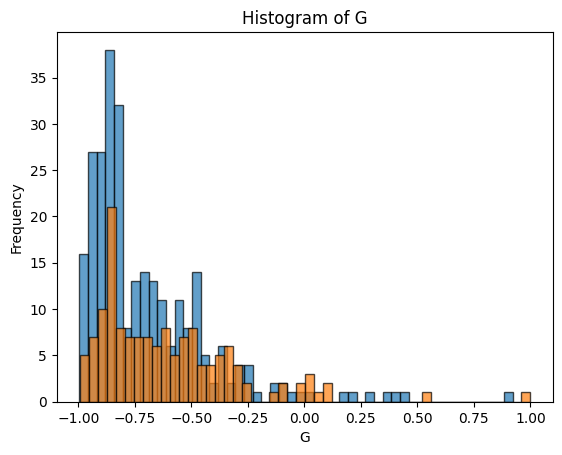

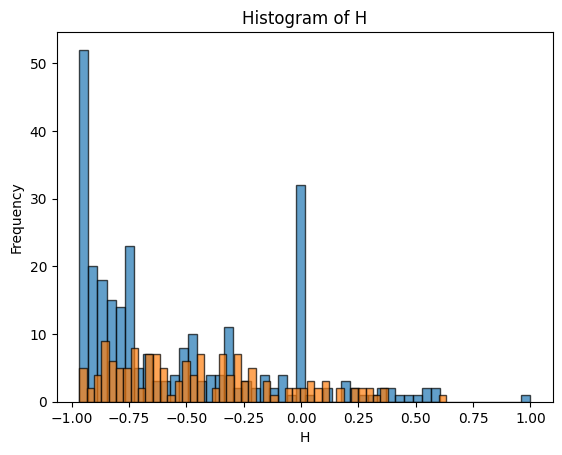

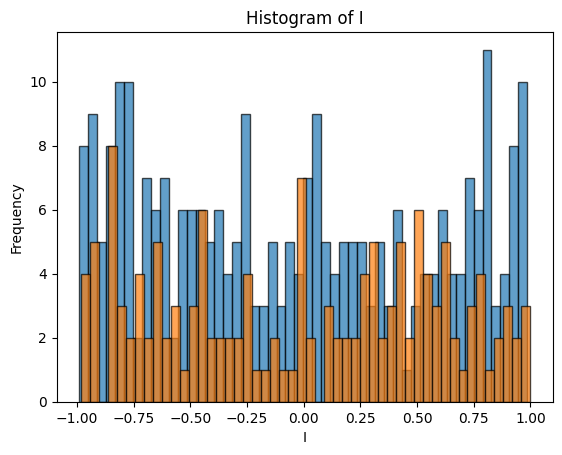

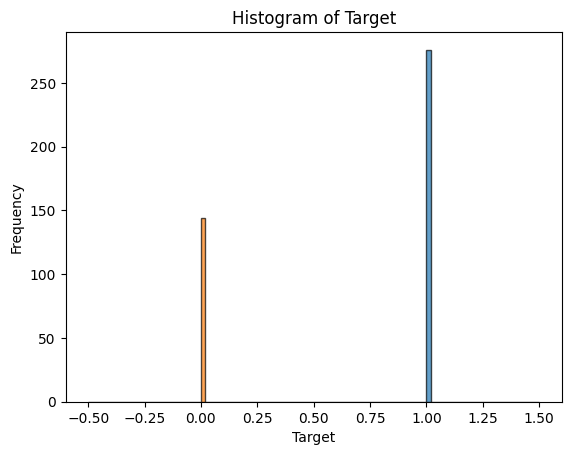

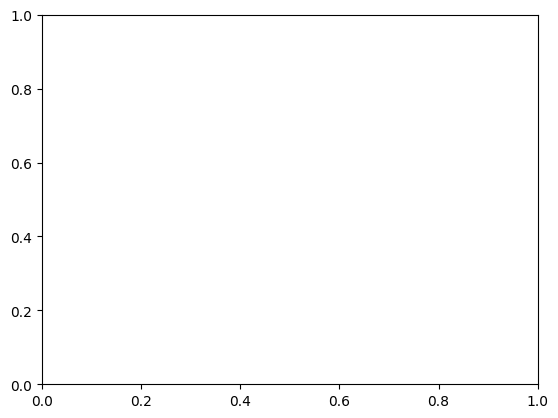

In [8]:
def histogram_binary(df):# 各列に対してヒストグラムを出力
    # zero_target_data = df[df[obj_column] == 0].copy()
    # df = pd.concat([df, zero_target_data], ignore_index=True)
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            
            plt.hist(df[df[obj_column] == 1][column], bins=50, edgecolor='black', alpha=0.7)
            plt.hist(df[df[obj_column] == 0][column], bins=50, edgecolor='black', alpha=0.7)
            plt.title(f'Histogram of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()
            # plt.savefig(f'../data/output/histogram_{column}.jpg')
            plt.cla()

histogram_binary(train_data)

In [9]:
def Prediction_accuracy(true, prediction, filename):
    # ROC曲線を計算
    fpr, tpr, thresholds = roc_curve(true, prediction)
    roc_auc = auc(fpr, tpr)

    # ROC曲線をプロット
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # AUCの値を図中に表記
    # plt.text(0.6, 0.2, f'AUC = {roc_auc:.2f}', bbox=dict(facecolor='white', alpha=0.5))

    # グリッドを表示
    plt.grid(True)

    # プロットを表示
    plt.show()


In [10]:
def lgb_run(data, obj_column):
    # 文字列変数をカテゴリ変数に変換
    string_columns = data.select_dtypes(include='object').columns
    data[string_columns] = data[string_columns].astype('category')

    train_data, test_data = train_test_split(data, test_size = 0.3, random_state = 123)
   # 説明変数と目的変数に分ける
    x_train = train_data.drop(obj_column, axis = 1)
    y_train = train_data[obj_column]
    x_test = test_data.drop(obj_column, axis = 1)
    y_test = test_data[obj_column]
    # LightGBM用のデータセットに入れる
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb.test = lgb.Dataset(x_test, y_test) 
    # LightGBMパラメータの設定
    params = {
        'objective': 'binary', # 2値分類
        'metric': 'auc', # 評価指標はAUC
        'boosting_type': 'gbdt', # Gradient Boosting Decision Tree
        'num_leaves': 31,
        'learning_rate': 0.02, # 少数データの場合は0.02~0.05くらい
        'feature_fraction': 1.0, # 小さくするほど過学習を抑えて学習息が上がる
        'n_estimators': 100000, # Early-Stoppingを使う場合は大きめに設定
        'importance_type': 'gain', # 特徴量の重要度
        'num_leaves': 31, # 大きくすると学習が進み過学習しやすくなる。8~256
        'random_seed': 1 # 乱数シード
    }
    # LightGBMモデルのトレーニング
    num_round = 100
    gbm = lgb.train(params, train_set=lgb_train, num_boost_round=num_round)
    # テストデータを用いて予測精度を確認する
    test_predicted = gbm.predict(x_test)
    # 学習曲線の描画
    lgb.plot_metric(gbm, ylim=(0.6, 1.2));
    plt.show()
    Prediction_accuracy(y_test, test_predicted, 'test.jpg')

In [79]:
def lgb_cv():
    ''' データの整形 '''
    y_train = train_data[obj_column] # 訓練データの目的変数を設定
    x_train = train_data.drop([obj_column], axis=1) # 訓練データの説明変数を設定
    category_list = x_train.columns[x_train.dtypes=='category'].values.tolist() # カテゴリ変数のリスト
    # LightGBM ハイパーパラメーターの設定
    lgbm_params = {
        'boosting_type': 'gbdt', # Gradient Boosting Decision Tree
        'objective': 'binary', # 2値分類
        'metric': 'auc', # 評価指標
        'learning_rate': 0.02, # デフォルトは0.1ですが、数万程度のデータ数の場合は、0.02〜0.05に設定することが多いです。
        'n_estimators': 100000, # Early-Stoppingを使いますので、大きめに設定
        'importance_type': 'gain', # 特徴量の重要度取得用。 gainが一般的
        # -- モデルの学習促進 --大きくすると、学習は進みますが、過学習しやすくなる。
        'num_leaves': 100, # 8〜256 30
        # -- モデルの過学習抑制 -- # 大きくすることで、過学習を抑制できます。
        'bagging_freq': 1, # 1にすると、決定木作成ごとに、毎回、サンプリングが実行される。（デフォルトは0）
        'random_seed': 42 # 乱数設定。 数値はご自由に。
    }

    lgbm_candidate_params = {
        'lambda_l1': [1], # 0.01〜100
        'lambda_l2': [1], # 0.01〜100
        'num_leaves': [8, 30, 100], # 8〜256 30
        'feature_fraction': [0.1, 0.5, 1.0], # 小さくするほど、過学習を抑え、学習速度もあがる。
        'bagging_fraction': [0.1, 0.5, 1.0], # 小さくするほど、過学習を抑え、学習速度もあがる。
        'min_data_in_leaf': [5, 20, 50], # 5〜200
        'min_sum_hessian_in_leaf': [1*1e-3, 1*1e-2], # 1e-5 〜 1e-2
    }

    ''' StratifiedKFold-CV '''
    folds = 5 # fold数の設定
    models = [] # CV毎の学習済みモデルを格納するリスト
    auc = [] # CV毎のAUCを格納するリスト
    out_of_fold = np.zeros(len(x_train)) # 検証データのpredictを格納するNumPy配列
    imp_df = pd.DataFrame() # 説明変数の重要度を整理するDFを用意
    out_of_fold_true = np.zeros(len(x_train)) # true(正解ラベル)を格納する配列
    valid_index_list = [] # 検証用indexを格納していくリストを用意
    cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=1).split(x_train, y_train))

    for n_fold in tqdm(range(folds)):
        train_index = cv[n_fold][0] # 学習用データのindex取得
        valid_index = cv[n_fold][1] # 検証用データのindex取得
        x_train_cv = x_train.iloc[train_index] # 学習用データの、説明変数
        y_train_cv = y_train.iloc[train_index] # 学習用データの、目的変数
        x_valid_cv = x_train.iloc[valid_index] # 検証用データの、説明変数
        y_valid_cv = y_train.iloc[valid_index] # 検証用データの、目的変数
    
        # LightGBMモデル・オブジェクトの生成
        model = lgb.LGBMClassifier(**lgbm_params)
        gscv = GridSearchCV(estimator=model, param_grid=lgbm_candidate_params, cv=folds, n_jobs=cpu_count())
        gscv.fit(
            x_train_cv, 
            y_train_cv, 
            eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
            categorical_feature = category_list,  
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=True), # early_stopping用コールバック関数
                lgb.log_evaluation(500) # コマンドライン出力用コールバック関数
            ]
        )
        lgbm_params = {**lgbm_params, **gscv.best_params_}
        print(gscv.best_params_)
        print(lgbm_params)
        model = lgb.LGBMClassifier(**lgbm_params)
        model.fit(
            x_train_cv, 
            y_train_cv, 
            eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
            categorical_feature = category_list,  
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=True), # early_stopping用コールバック関数
                lgb.log_evaluation(500) # コマンドライン出力用コールバック関数
            ]
        )
        # best_params = grid_search.best_params_
        # best_iteration = grid_search.best_estimator_.best_iteration_
        # 学習用データ・検証用データの予測
        y_pred_train = model.predict_proba(x_train_cv, num_iteration=model.best_iteration_)[:, 1]
        y_pred_valid = model.predict_proba(x_valid_cv, num_iteration=model.best_iteration_)[:, 1]

        ''' 結果の評価・保存 '''
        models.append(model) # モデルの保存
        valid_index_list.extend(valid_index) # 検証用データのindexを保存
        out_of_fold_true[valid_index] = y_valid_cv # 検証用データの正解ラベルの保存
        out_of_fold[valid_index] = y_pred_valid # 検証用データの予測結果の保存
        # AUCの計算・表示・保存
        temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
        temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)
        print(f'\nauc(train_data) = {temp_auc_train:.3f}')
        print(f'auc(valid_data) = {temp_auc_valid:.3f}\n')
        auc.append([temp_auc_train, temp_auc_valid])
        # Feature Importanceの保存
        temp_imp = pd.DataFrame({
            'col': x_train.columns, 
            'imp': model.feature_importances_
        })
        imp_df = pd.concat(
            [imp_df, temp_imp], 
            axis=0, 
            ignore_index=True
        )
        # 学習曲線の描画
        lgb.plot_metric(model, ylim=(0.6, 1.2))
        plt.show()

        # ROC曲線の描画
        FPR, TPR, thresholds = roc_curve(y_true=y_valid_cv, y_score=y_pred_valid) # ROC曲線
        plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='Ideal') # 理想線
        plt.plot([0, 1], [0, 1], linestyle='--', label='Random') # ランダムな推定線
        plt.plot(FPR, TPR)
        plt.legend()
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

    ''' FoldsのFeature Importance結果を整形 '''
    imp_group_df = imp_df.groupby('col')['imp'].agg(['mean', 'std'])
    imp_group_df.columns = ['imp_mean', 'imp_std'] # カラム名の変更
    imp_group_df = imp_group_df.reset_index(drop=False) # indexをリセット
    imp_group_df.sort_values('imp_mean', ascending=False, ignore_index=True) # imp_meanでソート
    print(imp_group_df)

    ''' FoldsのAUC結果の整形 '''
    auc_np = np.array(auc)
    auc_train_mean = auc_np[:, 0].mean() # 学習データのpredictに対する、平均auc
    auc_valid_mean = auc_np[:, 1].mean() # 検証データのpredictに対する、平均auc
    print(f'auc(train_data)_mean = {auc_train_mean:.3f}')
    print(f'auc(valid_data)_mean = {auc_valid_mean:.3f}')

    ''' ROC曲線の描画 '''
    FPR, TPR, thresholds = roc_curve(y_true=y_train, y_score=out_of_fold) # ROC曲線　検証データ全体
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='Ideal') # 理想線
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random') # ランダムな推定線
    plt.plot(FPR, TPR) # ROC曲線
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    return models

In [ ]:
def lgb_optuna_ncv():
    ''' データの整形 '''
    y_train = train_data[obj_column] # 訓練データの目的変数を設定
    x_train = train_data.drop([obj_column], axis=1) # 訓練データの説明変数を設定
    category_list = x_train.columns[x_train.dtypes=='category'].values.tolist() # カテゴリ変数のリスト
    ''' LightGBM ハイパーパラメーターの設定 '''
    lgbm_params = {
        'boosting_type': 'gbdt', # Gradient Boosting Decision Tree
        'objective': 'binary', # 2値分類
        'metric': 'auc', # 評価指標
        'learning_rate': 0.02, # デフォルトは0.1ですが、数万程度のデータ数の場合は、0.02〜0.05に設定することが多いです。
        'n_estimators': 100000, # Early-Stoppingを使いますので、大きめに設定
        'importance_type': 'gain', # 特徴量の重要度取得用。 gainが一般的
        # -- モデルの学習促進 --大きくすると、学習は進みますが、過学習しやすくなる。
        'num_leaves': 100, # 8〜256 30
        # -- モデルの過学習抑制 -- # 大きくすることで、過学習を抑制できます。
        'bagging_freq': 1, # 1にすると、決定木作成ごとに、毎回、サンプリングが実行される。（デフォルトは0）
        'random_seed': 42 # 乱数設定。 数値はご自由に。
    }
    lgbm_candidate_params = {
        'lambda_l1': [1], # 0.01〜100
        'lambda_l2': [1], # 0.01〜100
        'num_leaves': [8, 30, 100], # 8〜256 30
        'feature_fraction': [0.1, 0.5, 1.0], # 小さくするほど、過学習を抑え、学習速度もあがる。
        'bagging_fraction': [0.1, 0.5, 1.0], # 小さくするほど、過学習を抑え、学習速度もあがる。
        'min_data_in_leaf': [5, 20, 50], # 5〜200
        'min_sum_hessian_in_leaf': [1*1e-3, 1*1e-2], # 1e-5 〜 1e-2
    }

    ''' StratifiedKFold-CV '''
    outer_folds = 5 # 検証用のfold数の設定
    inner_folds = 5 # ハイパラ調整用のfold数の設定
    models = [] # 学習済みモデルを格納するリスト
    auc = [] # AUCを格納するリスト
    out_of_fold = np.zeros(len(x_train)) # 検証データのpredictを格納するNumPy配列
    imp_df = pd.DataFrame() # 説明変数の重要度を整理するDFを用意
    out_of_fold_true = np.zeros(len(x_train)) # true(正解ラベル)を格納する配列
    valid_index_list = [] # 検証用indexを格納していくリストを用意
    outer_cv = list(StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=1).split(x_train, y_train))

    # for num_outer_cv, (i_outer_cv_tr, i_outer_cv_val) in enumerate(outer_cv.split(x_train, y_train)):
    #     indices_outer_cv_tr, indices_outer_cv_val = df_train_cv.index[i_outer_cv_tr], df_train_cv.index[i_outer_cv_val]
    #     df_tr, df_val = df_train_cv.loc[indices_outer_cv_tr], df_train_cv.loc[indices_outer_cv_val]

    #     indices_outer_cv_dict[f"outer_cv_{num_outer_cv}"] = {"tr": indices_outer_cv_tr, "val": indices_outer_cv_val}
    #     indices_inner_cv_dict[f"outer_cv_{num_outer_cv}"] = {}

    #     inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=seed)

    #     for num_inner_cv, (i_inner_cv_tr, i_inner_cv_val) in enumerate(fold_inner_cv.split(df_tr, df_tr[obj_var])):
    #         indices_inner_cv_tr, indices_inner_cv_val = df_tr.index[i_inner_cv_tr], df_tr.index[i_inner_cv_val]
    #         indices_inner_cv_dict[f"outer_cv_{num_outer_cv}"][f"inner_cv_{num_inner_cv}"] = {"tr": indices_inner_cv_tr, "val": indices_inner_cv_val}

    for n_outer_fold in range(outer_folds):
        train_index = outer_cv[n_outer_fold][0] # 学習用データのindex取得
        valid_index = outer_cv[n_outer_fold][1] # 検証用データのindex取得
        x_train_cv = x_train.iloc[train_index] # 学習用データの説明変数
        y_train_cv = y_train.iloc[train_index] # 学習用データの目的変数
        x_valid_cv = x_train.iloc[valid_index] # 検証用データの説明変数
        y_valid_cv = y_train.iloc[valid_index] # 検証用データの目的変数
        
        for n_inner_fold in range(inner_folds):
            # optimization
            study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))
            study.optimize(objective, n_trials=num_trials)
            pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
            complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
        # LightGBMモデル・オブジェクトの生成
        model = lgb.LGBMClassifier(**lgbm_params)
        gscv = GridSearchCV(estimator=model, param_grid=lgbm_candidate_params, cv=folds, n_jobs=cpu_count())
        gscv.fit(
            x_train_cv, 
            y_train_cv, 
            eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
            categorical_feature = category_list,  
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=True), # early_stopping用コールバック関数
                lgb.log_evaluation(500) # コマンドライン出力用コールバック関数
            ]
        )
        lgbm_params = {**lgbm_params, **gscv.best_params_}
        print(gscv.best_params_)
        print(lgbm_params)
        model = lgb.LGBMClassifier(**lgbm_params)
        model.fit(
            x_train_cv, 
            y_train_cv, 
            eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
            categorical_feature = category_list,  
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=True), # early_stopping用コールバック関数
                lgb.log_evaluation(500) # コマンドライン出力用コールバック関数
            ]
        )
        # best_params = grid_search.best_params_
        # best_iteration = grid_search.best_estimator_.best_iteration_
        # 学習用データ・検証用データの予測
        y_pred_train = model.predict_proba(x_train_cv, num_iteration=model.best_iteration_)[:, 1]
        y_pred_valid = model.predict_proba(x_valid_cv, num_iteration=model.best_iteration_)[:, 1]

        ''' 結果の評価・保存 '''
        models.append(model) # モデルの保存
        valid_index_list.extend(valid_index) # 検証用データのindexを保存
        out_of_fold_true[valid_index] = y_valid_cv # 検証用データの正解ラベルの保存
        out_of_fold[valid_index] = y_pred_valid # 検証用データの予測結果の保存
        # AUCの計算・表示・保存
        temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
        temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)
        print(f'\nauc(train_data) = {temp_auc_train:.3f}')
        print(f'auc(valid_data) = {temp_auc_valid:.3f}\n')
        auc.append([temp_auc_train, temp_auc_valid])
        # Feature Importanceの保存
        temp_imp = pd.DataFrame({
            'col': x_train.columns, 
            'imp': model.feature_importances_
        })
        imp_df = pd.concat(
            [imp_df, temp_imp], 
            axis=0, 
            ignore_index=True
        )
        # 学習曲線の描画
        lgb.plot_metric(model, ylim=(0.6, 1.2))
        plt.show()

        # ROC曲線の描画
        FPR, TPR, thresholds = roc_curve(y_true=y_valid_cv, y_score=y_pred_valid) # ROC曲線
        plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='Ideal') # 理想線
        plt.plot([0, 1], [0, 1], linestyle='--', label='Random') # ランダムな推定線
        plt.plot(FPR, TPR)
        plt.legend()
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

    ''' FoldsのFeature Importance結果を整形 '''
    imp_group_df = imp_df.groupby('col')['imp'].agg(['mean', 'std'])
    imp_group_df.columns = ['imp_mean', 'imp_std'] # カラム名の変更
    imp_group_df = imp_group_df.reset_index(drop=False) # indexをリセット
    imp_group_df.sort_values('imp_mean', ascending=False, ignore_index=True) # imp_meanでソート
    print(imp_group_df)

    ''' FoldsのAUC結果の整形 '''
    auc_np = np.array(auc)
    auc_train_mean = auc_np[:, 0].mean() # 学習データのpredictに対する、平均auc
    auc_valid_mean = auc_np[:, 1].mean() # 検証データのpredictに対する、平均auc
    print(f'auc(train_data)_mean = {auc_train_mean:.3f}')
    print(f'auc(valid_data)_mean = {auc_valid_mean:.3f}')

    ''' ROC曲線の描画 '''
    FPR, TPR, thresholds = roc_curve(y_true=y_train, y_score=out_of_fold) # ROC曲線　検証データ全体
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='Ideal') # 理想線
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random') # ランダムな推定線
    plt.plot(FPR, TPR) # ROC曲線
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    return models

In [76]:
def generate_submission(models):
    preds_test = [] # CV毎の学習済みモデルによる予測結果を格納するリスト
    # CV毎の学習済みモデルでpredictを実行
    for model in models:
        pred = model.predict_proba(test_data, num_iteration=model.best_iteration_)[:, 1] # predict
        preds_test.append(pred) # 結果をリストにappend
    preds_test_np = np.array(preds_test) # preds_testリストを、NumPy配列に変換
    ranked_data = np.argsort(np.argsort(preds_test_np, axis=1), axis=1) + 1# 各列ごとにランクをつける
    print(ranked_data.T)
    # weights = np.array([0.721, 0.863, 0.839, 0.854, 0.817])  # 重み
    weights = np.array([1, 5, 3, 4, 2])  # 重み
    average_rank_per_row = np.average(ranked_data.T, weights=weights, axis=1)
    # average_rank_per_row = np.mean(ranked_data, axis=0) # 各行のランクの平均を計算
    # preds_test_np_mean = preds_test_np.mean(axis=0) # 平均を取得
    # 予測値から、submissionファイルを作成
    submission['Target'] = average_rank_per_row
    submission.to_csv('./submission_weighted_rank.csv', index=False)
    submission

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytr

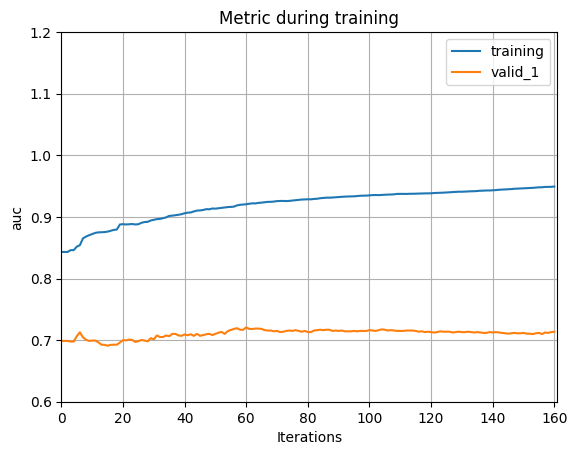

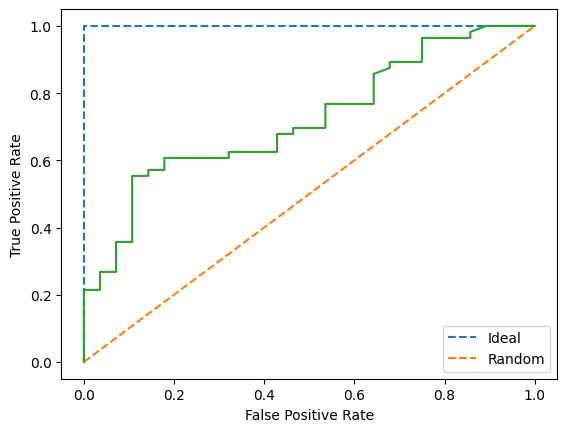

 20%|██        | 1/5 [01:46<07:07, 106.78s/it]

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytr

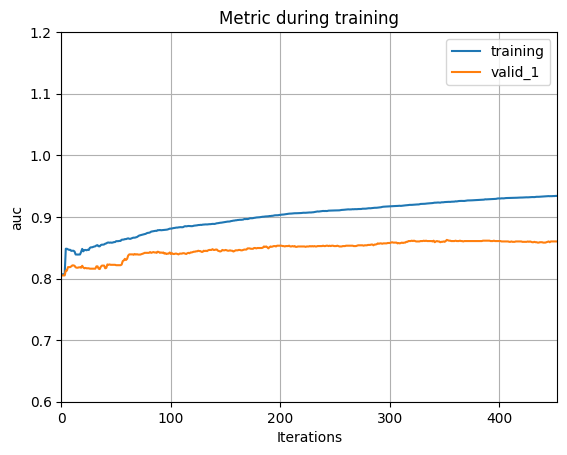

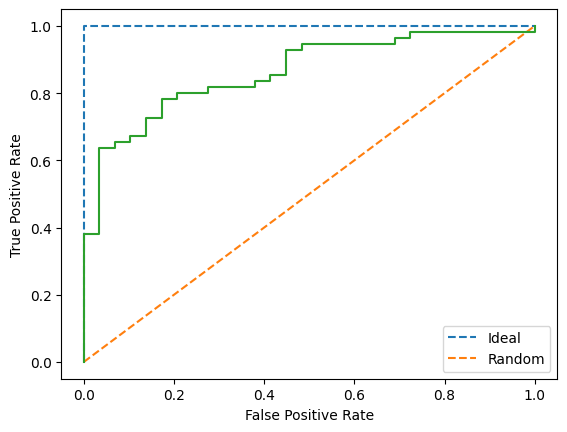

 40%|████      | 2/5 [03:29<05:12, 104.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytr

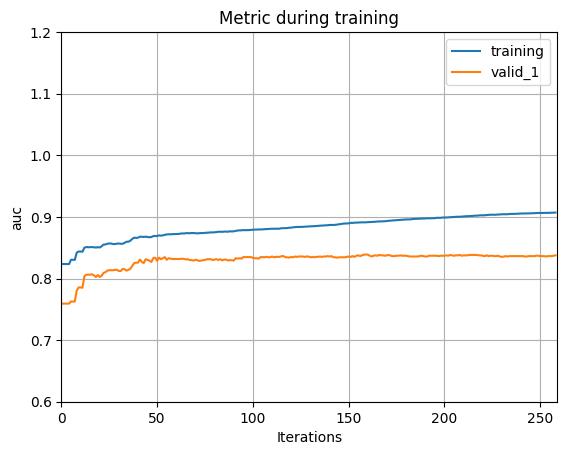

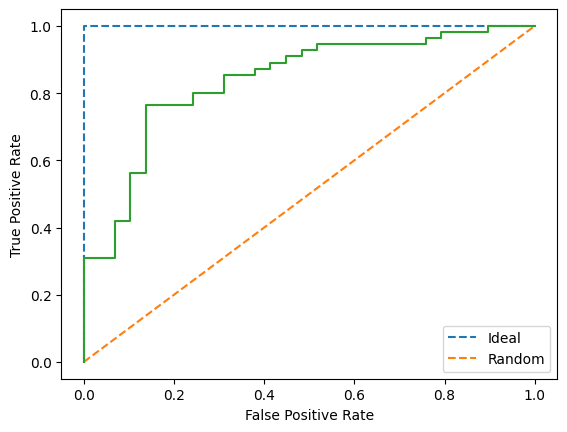

 60%|██████    | 3/5 [05:07<03:22, 101.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytr

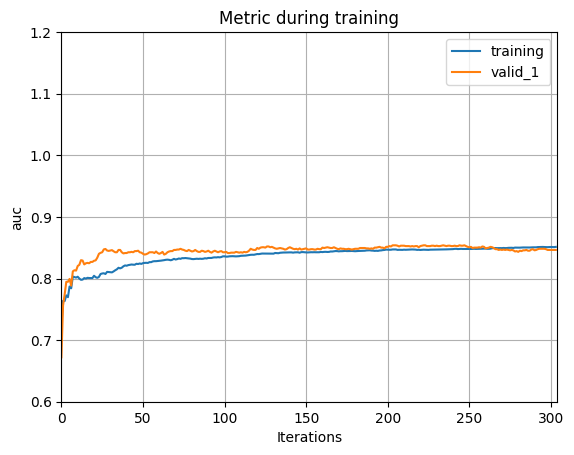

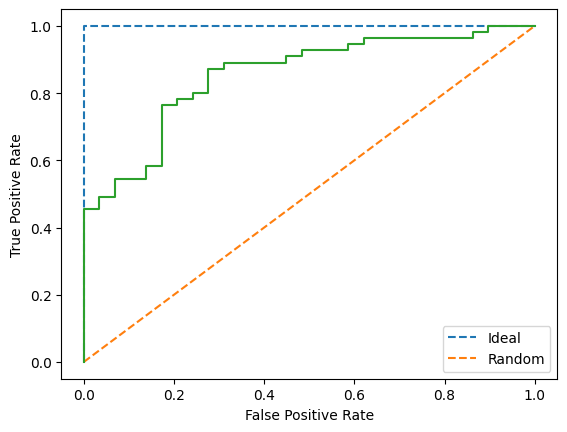

 80%|████████  | 4/5 [06:45<01:40, 100.13s/it]

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytr

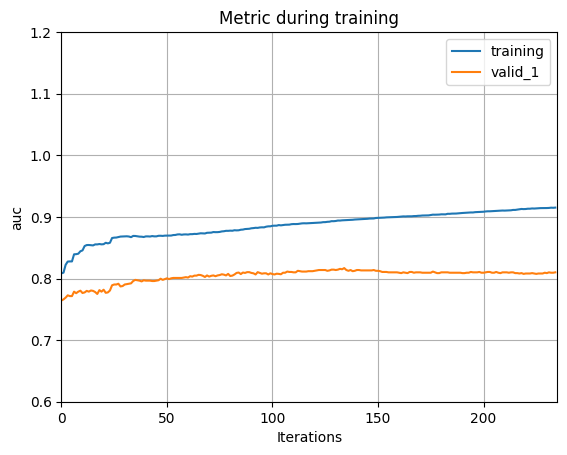

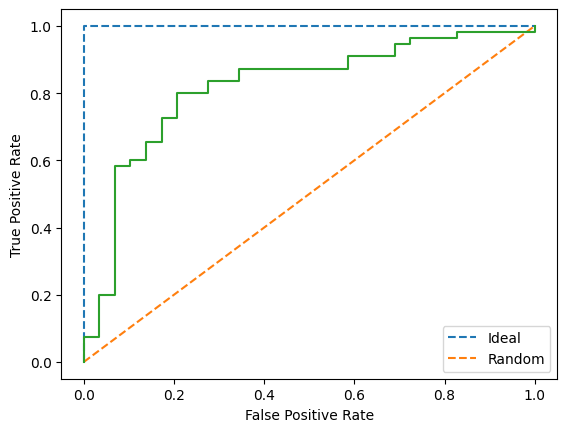

100%|██████████| 5/5 [07:51<00:00, 94.38s/it] 


  col     imp_mean     imp_std
0   A   125.085943   79.978087
1   B  1666.467577  441.308774
2   C    43.348842   39.457539
3   D    61.735304   52.277274
4   E    86.982392   52.633582
5   F   680.880786  161.001170
6   G   165.421014   65.042781
7   H   276.988700  126.907259
8   I   126.449104   76.197023
auc(train_data)_mean = 0.896
auc(valid_data)_mean = 0.819


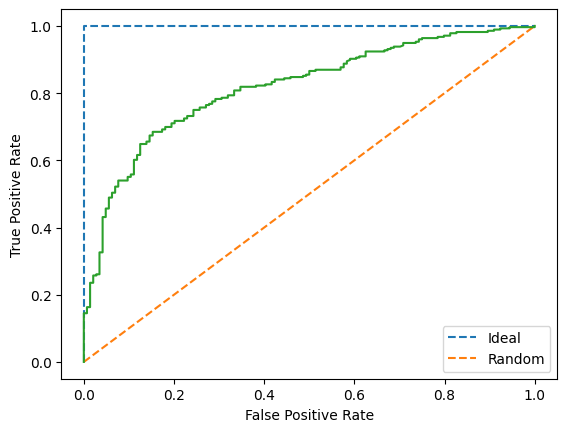

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytr

In [80]:

# lgb_run(train_data, obj_column)
models = lgb_cv()
generate_submission(models)

In [38]:
save_models = []
save_models.append(models)

In [78]:
generate_submission(save_models[0])

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytr

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytr

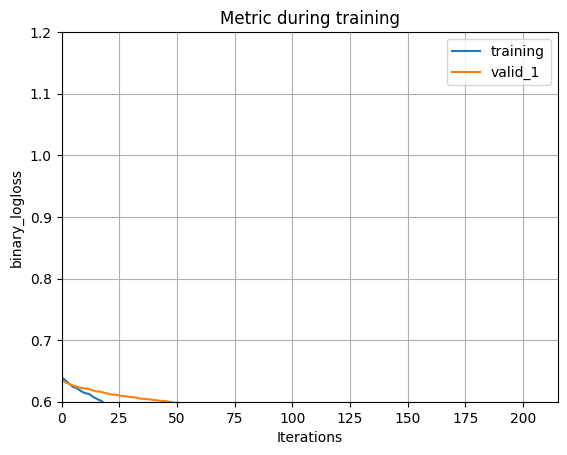

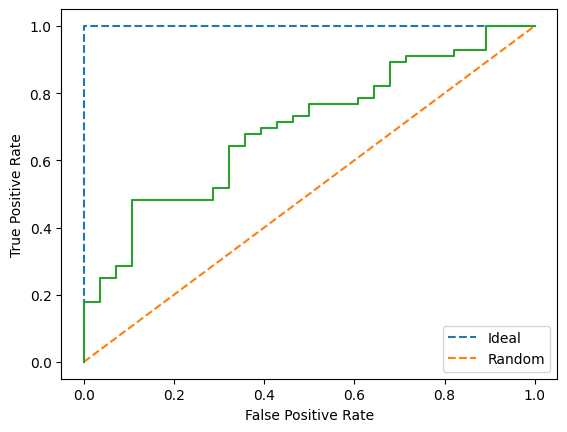

 20%|██        | 1/5 [01:47<07:08, 107.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1

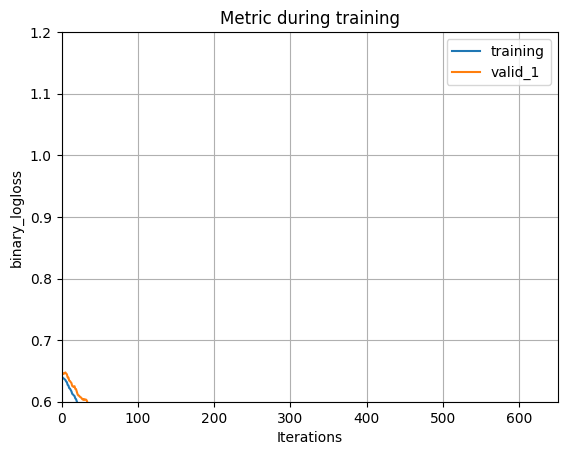

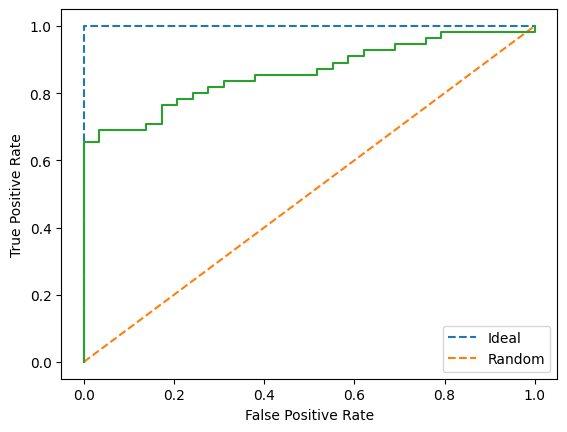

 40%|████      | 2/5 [05:11<08:13, 164.44s/it]

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytr

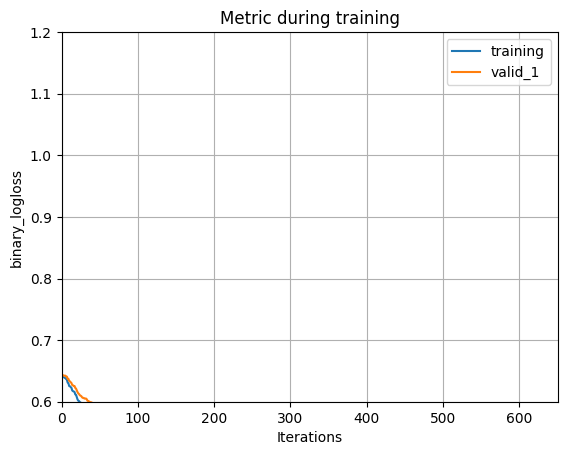

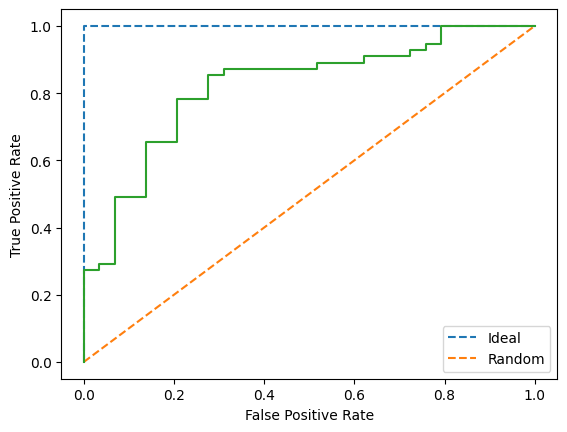

 60%|██████    | 3/5 [08:39<06:08, 184.35s/it]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1

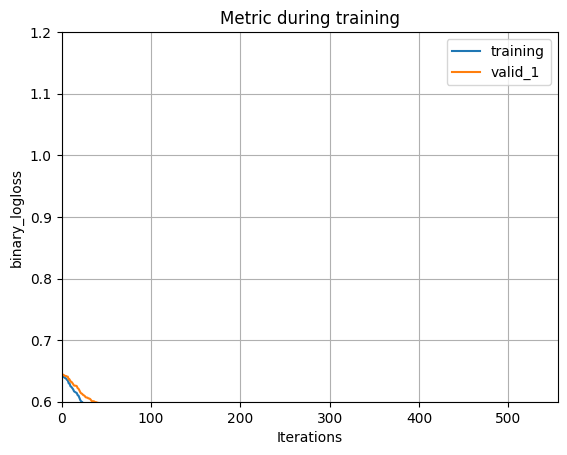

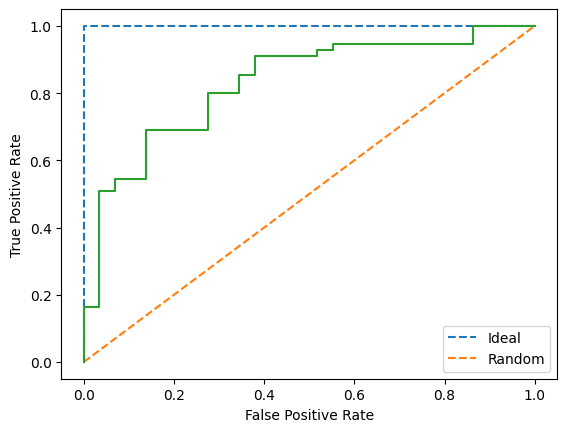

 80%|████████  | 4/5 [11:29<02:58, 178.68s/it]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytr

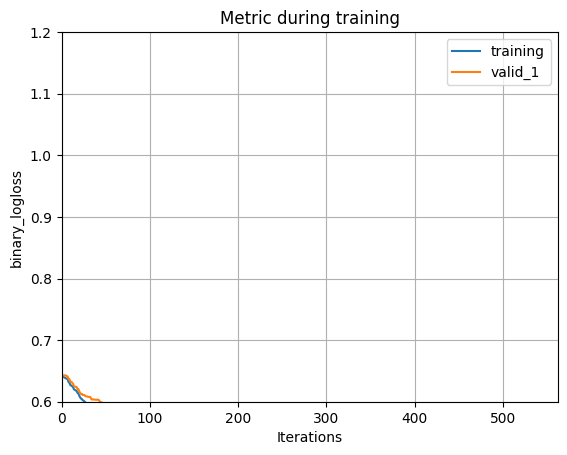

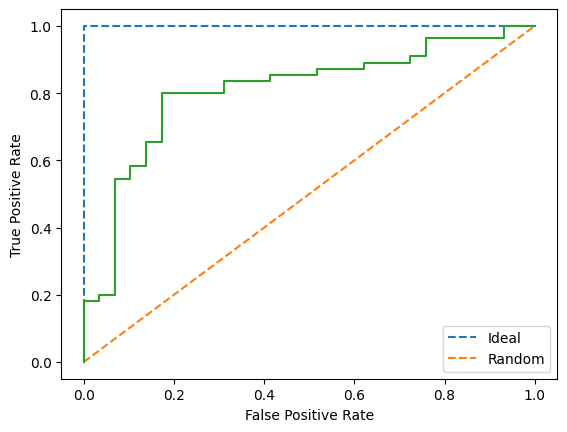

100%|██████████| 5/5 [14:12<00:00, 170.44s/it]


  col     imp_mean     imp_std
0   A   140.739578   78.951745
1   B  1008.264988  323.222814
2   C   137.847238   68.262051
3   D   159.641109   88.947138
4   E   207.247736  126.703959
5   F   529.107612  168.971002
6   G   190.580692   64.630075
7   H   328.859092  185.334793
8   I   227.191330  126.693933
auc(train_data)_mean = 0.914
auc(valid_data)_mean = 0.803


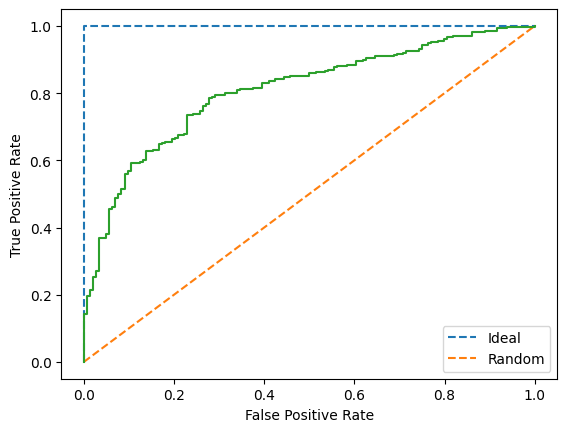

In [40]:
models = lgb_cv()

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, co

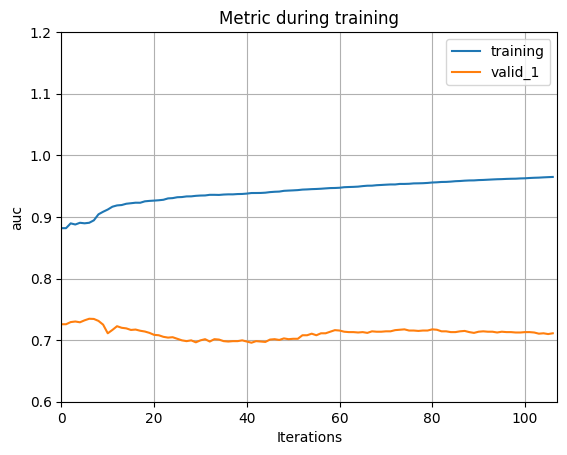

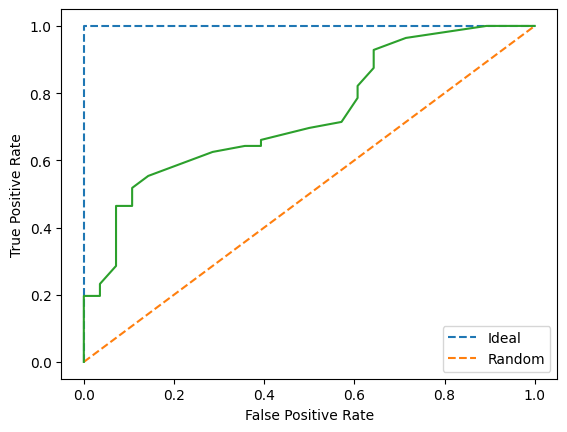

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, co

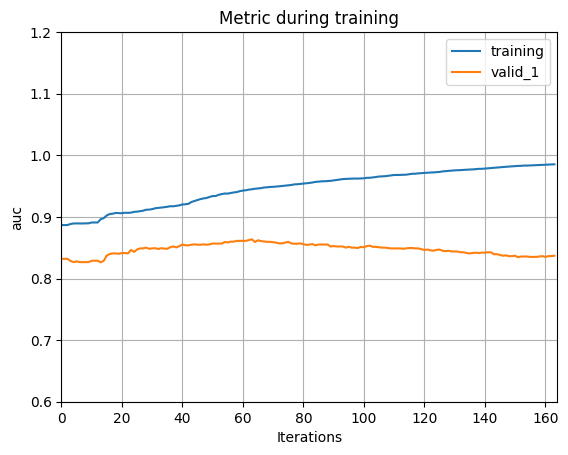

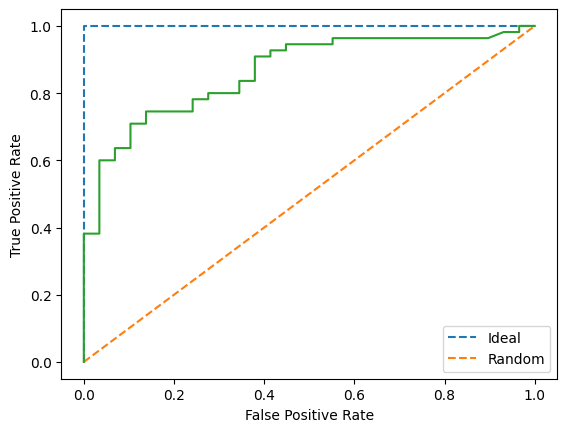

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, co

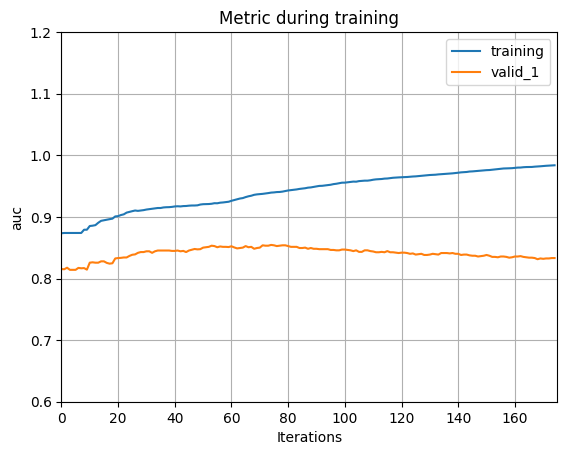

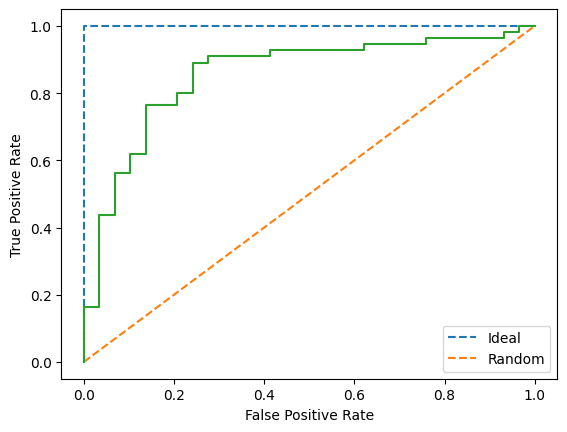

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, co

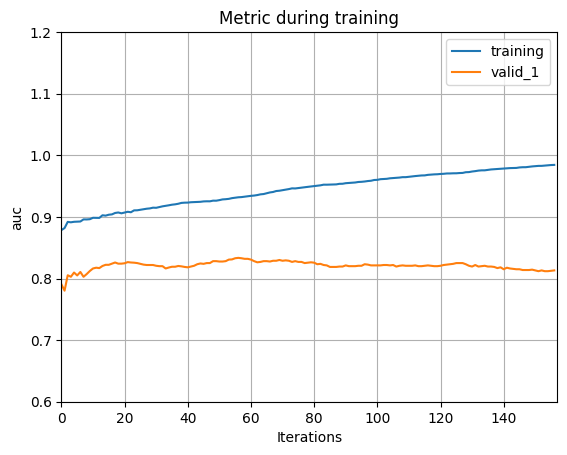

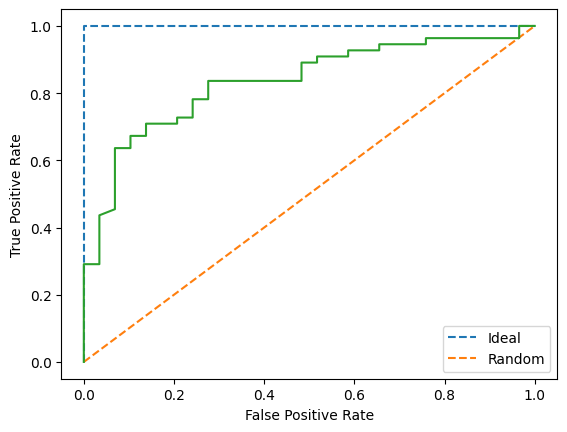

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, co

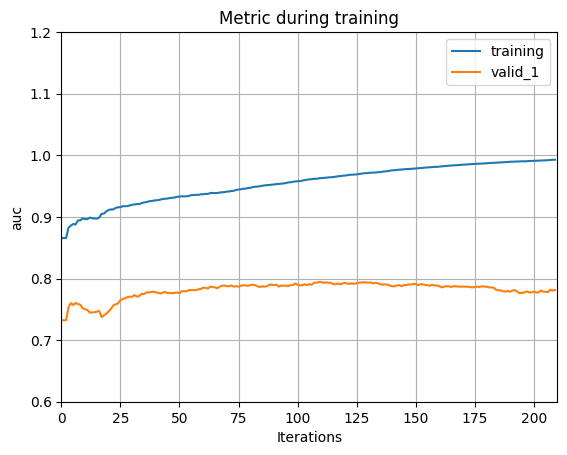

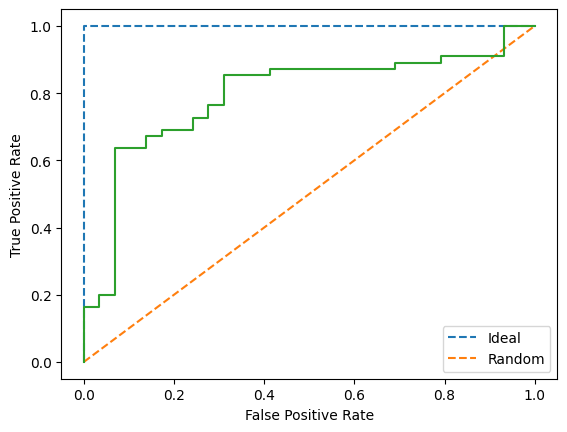

   col     imp_mean     imp_std
0    A   145.035323   82.575257
1    B  1707.942997  671.335067
2    C    79.164405   92.084653
3    D   101.327845   73.537977
4   DD     1.944469    3.890181
5    E   159.219215  148.576567
6   EE     8.912200   12.587463
7    F   690.748417  311.802989
8    G   276.549081  193.767104
9    H   335.332471  144.796961
10   I   275.737007  218.109798
auc(train_data)_mean = 0.934
auc(valid_data)_mean = 0.816


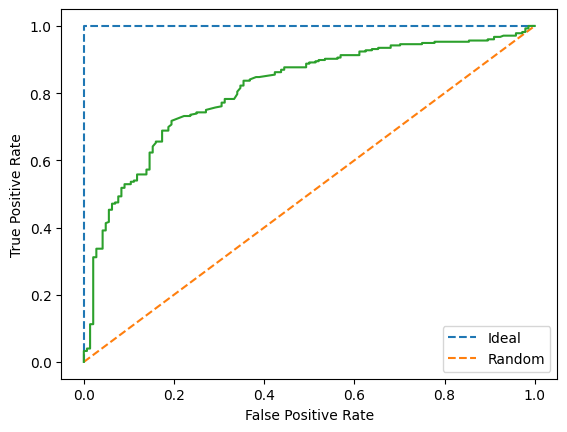

In [14]:
# 特徴量の追加
train_data['DD'] = train_data['D'].apply(lambda x: 0 if x == 0 else 1)
train_data['EE'] = train_data['E'].apply(lambda x: 0 if x == 0 else 1)
test_data['DD'] = test_data['D'].apply(lambda x: 0 if x == 0 else 1)
test_data['EE'] = test_data['E'].apply(lambda x: 0 if x == 0 else 1)

models = lgb_cv()